# Health Analytics

In [2]:
from IPython.display import Image

# Background Information

We’ve just received an urgent request from the General Manager of Analytics at Health Co. requesting our assistance with their analysis.

The Health Co. analytics team have shared with us their SQL script - they unfortunately ran into a few bugs that they couldn’t fix!

We’ve been asked to quickly debug their SQL script and use the resulting query outputs to answer a few questions that the GM has requested for a board meeting about their active users.

# Dataset Overview

The dataset under analysis: ```health.user_logs```

This real world messy dataset captures data taken from individuals logging their measurements via an online portal throughout the day.

Multiple measurements can be taken on the same day at different times.

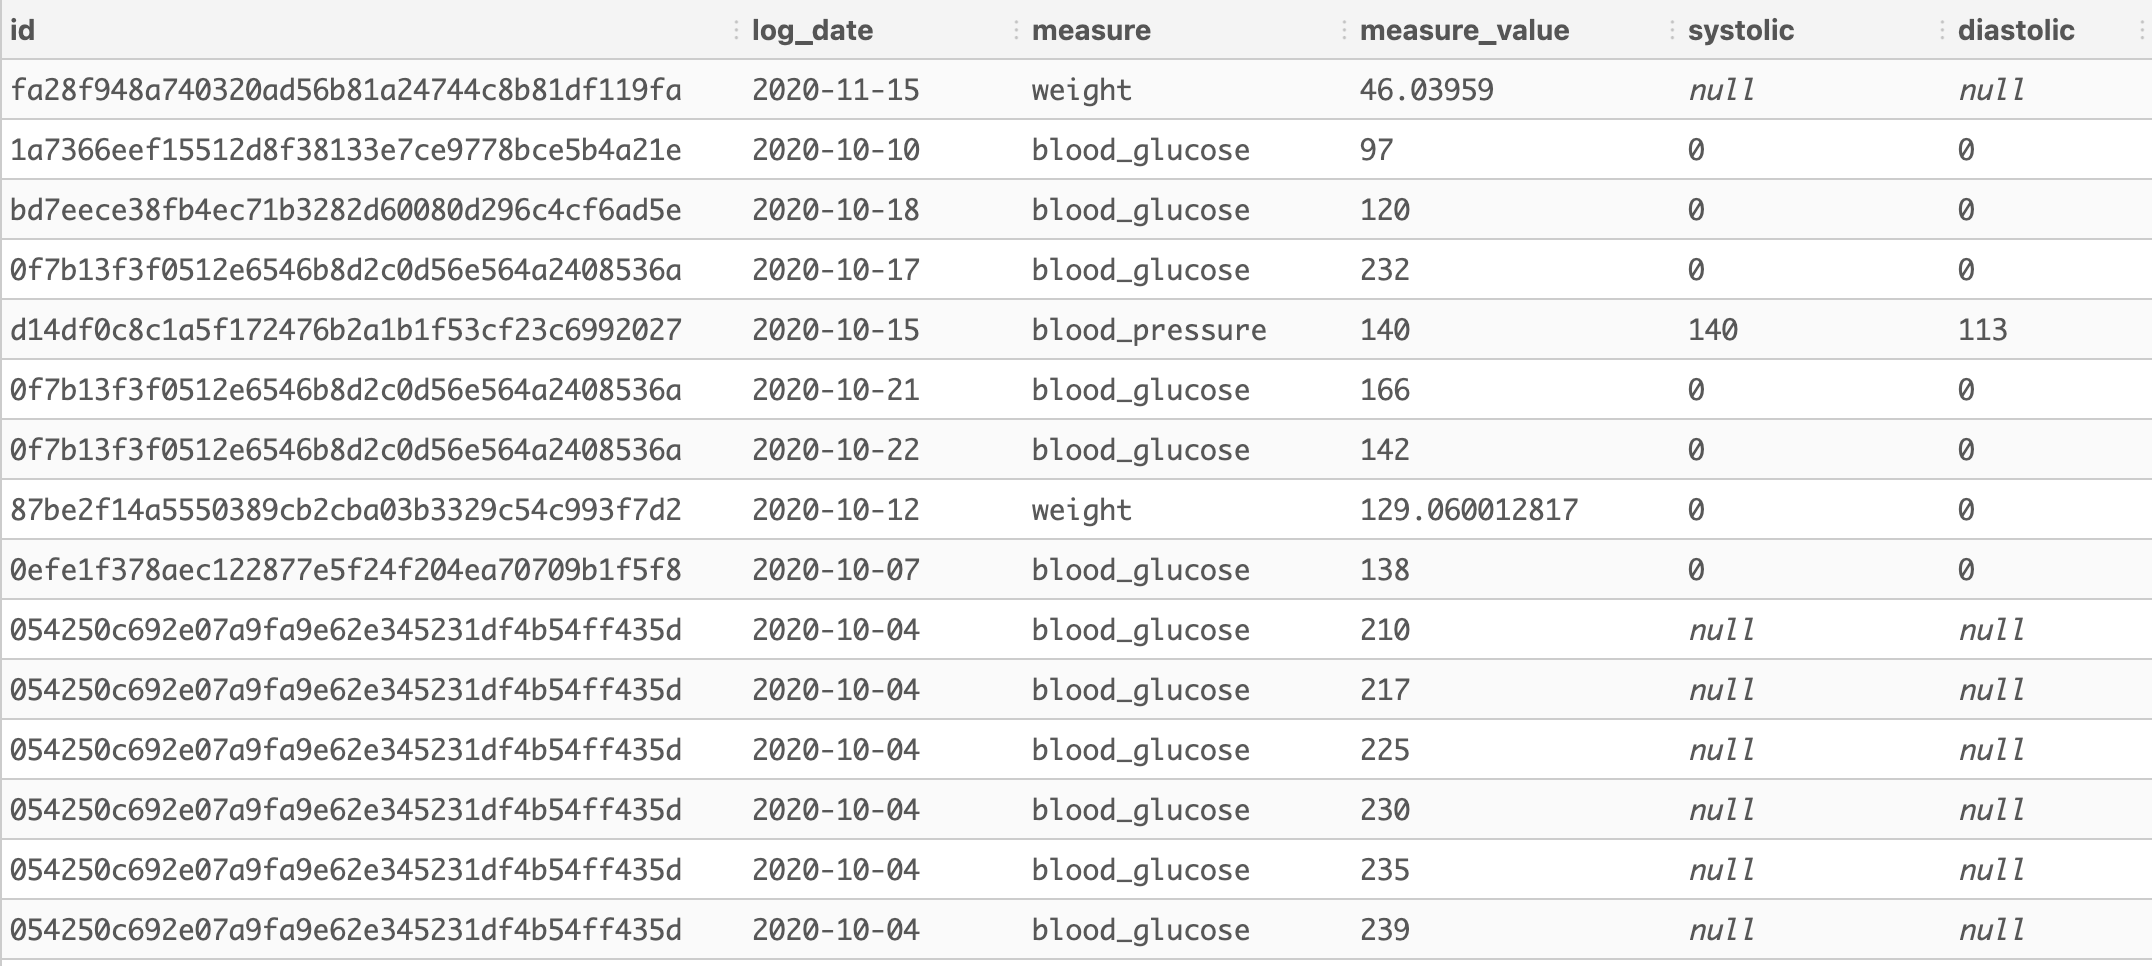

In [3]:
Image(filename="./resources/health_user_logs.png")

# Business Questions

1. How many unique users exist in the logs dataset?
2. How many total measurements do we have per user on average?
3. What about the median number of measurements per user?
4. How many users have 3 or more measurements?
5. How many users have 1,000 or more measurements?

Looking at the logs data - what is the number of the active user base who:

6. Have logged blood glucose measurements?
7. Have at least 2 types of measurements?
8. Have all 3 measures - blood glucose, weight and blood pressure?

For users that have blood pressure measurements:

9. What is the median systolic/diastolic blood pressure values?

# Before Debugging

```sql
-- 1. How many unique users exist in the logs dataset?
SELECT
  COUNT DISTINCT user_id
FROM health.user_logs;

-- for questions 2-8 we created a temporary table
DROP TABLE IF EXISTS user_measure_count;
CREATE TEMP TABLE user_measure_cout
SELECT
    id,
    COUNT(*) AS measure_count,
    COUNT(DISTINCT measure) as unique_measures
  FROM health.user_logs
  GROUP BY 1; 

-- 2. How many total measurements do we have per user on average?
SELECT
  ROUND(MEAN(measure_count))
FROM user_measure_count;

-- 3. What about the median number of measurements per user?
SELECT
  PERCENTILE_CONTINUOUS(0.5) WITHIN GROUP (ORDER BY id) AS median_value
FROM user_measure_count;

-- 4. How many users have 3 or more measurements?
SELECT
  COUNT(*)
FROM user_measure_count
HAVING measure >= 3;

-- 5. How many users have 1,000 or more measurements?
SELECT
  SUM(id)
FROM user_measure_count
WHERE measure_count >= 1000;

-- 6. Have logged blood glucose measurements?
SELECT
  COUNT DISTINCT id
FROM health.user_logs
WHERE measure is 'blood_sugar';

-- 7. Have at least 2 types of measurements?
SELECT
  COUNT(*)
FROM user_measure_count
WHERE COUNT(DISTINCT measures) >= 2;

-- 8. Have all 3 measures - blood glucose, weight and blood pressure?
SELECT
  COUNT(*)
FROM usr_measure_count
WHERE unique_measures = 3;

-- 9.  What is the median systolic/diastolic blood pressure values?
SELECT
  PERCENTILE_CONT(0.5) WITHIN (ORDER BY systolic) AS median_systolic
  PERCENTILE_CONT(0.5) WITHIN (ORDER BY diastolic) AS median_diastolic
FROM health.user_logs
WHERE measure is blood_pressure;
```

# After Debugging

***
***

```1. How many unique users exist in the logs dataset?```

```sql
SELECT
  COUNT(DISTINCT id) unique_users
FROM health.user_logs;
```

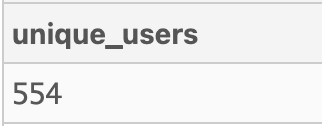

In [4]:
Image(filename="./resources/ha1.png")

There are 554 unique users

Original query tried to query ```user_id``` column which doesn't exist in the table. The correct column to query is ```id```

***
***

```For questions 2-8 we will create a temporary table```

```sql
-- for questions 2-8 we created a temporary table
DROP TABLE IF EXISTS user_measure_count;
CREATE TEMP TABLE user_measure_count AS(
    SELECT
        id,
        COUNT(*) AS measure_count,
        COUNT(DISTINCT measure) as unique_measures
      FROM health.user_logs
      GROUP BY 1
);
```

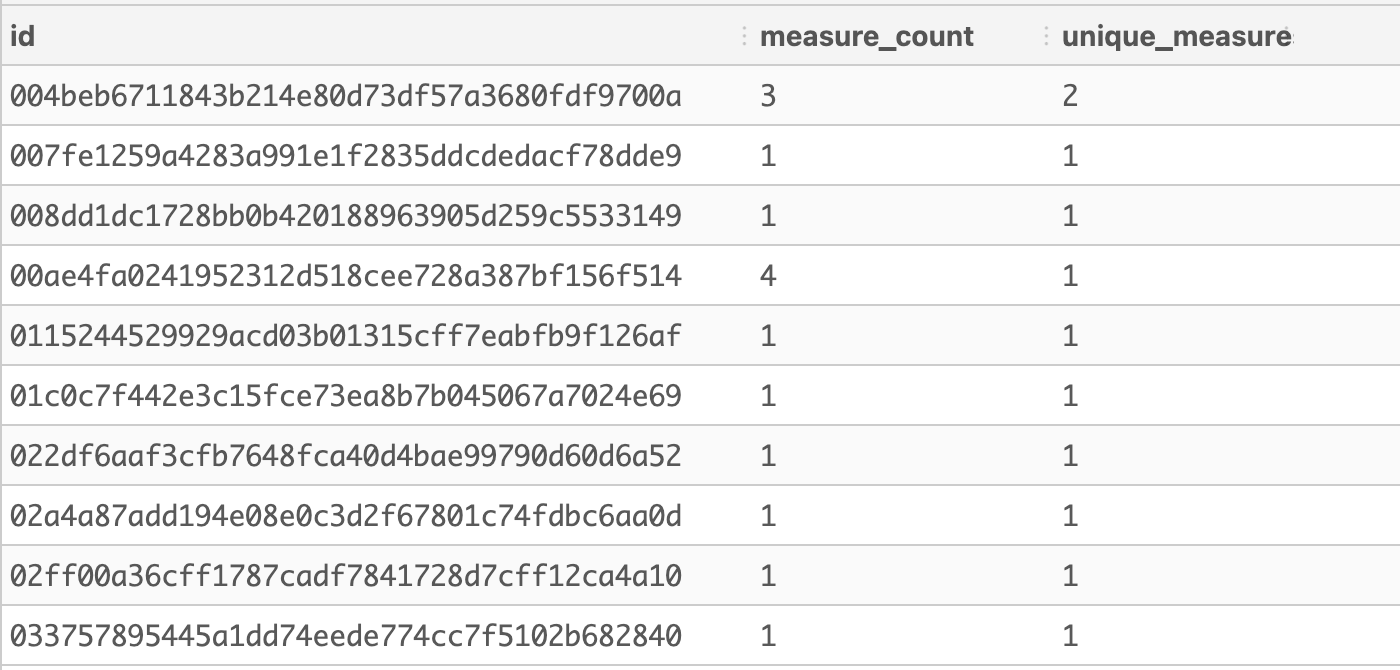

In [5]:
Image(filename="./resources/hae.png")

Original query had mispelt the temporary table name during creation and was missing the ``AS`` keyword

***
***

```2. How many total measurements do we have per user on average?```

```sql
SELECT
  ROUND(AVG(measure_count)) avg_total_measurements
FROM user_measure_count;
```

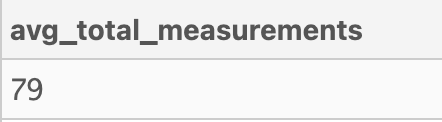

In [7]:
Image(filename="./resources/ha2.png")

On average, we have 79 total measurements per user.

The correct function to use is ```AVG()``` not ```MEAN()```

***
***

```3. What about the median number of measurements per user?```

```sql
SELECT
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY measure_count) median_value
FROM user_measure_count;
```

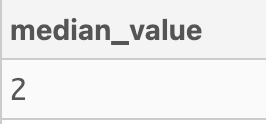

In [10]:
Image(filename="./resources/ha3.png")

Meadian measurements per user is 2

- ```PERCENTILE_CONT()``` is the correct function to use
- Need to order by ```measure_count``` not ```id```

***
***

```4. How many users have 3 or more measurements?```

```sql
SELECT
  COUNT(*) user_count
FROM user_measure_count
WHERE measure_count >= 3;
```

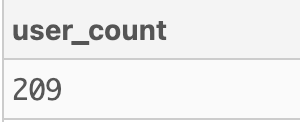

In [12]:
Image(filename="./resources/ha4.png")

209 customers have logged 3 or more measurements.

- ```WHERE``` is the correct clause to use not ```HAVING```
- incorrect column name has been in ```WHERE``` clause

***
***

```5. How many users have 1,000 or more measurements?```

```sql
SELECT
  SUM(id)
FROM user_measure_count
WHERE measure_count >= 1000;

SELECT
  COUNT(*) user_count
FROM user_measure_count
WHERE measure_count >= 1000;
```

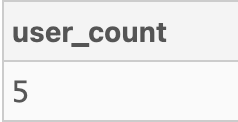

In [13]:
Image(filename="./resources/ha5.png")

5 users have logged 1000 or more measurements

- correct function to use is ```COUNT``` not ```SUM```

***
***

```6. What is the number and percentage of users who have logged blood glucose measurements?```

```sql
SELECT
  COUNT(DISTINCT id) FILTER (WHERE measure='blood_glucose') user_count,
  ROUND(100 * COUNT(DISTINCT id) FILTER(WHERE measure='blood_glucose')::NUMERIC / COUNT(DISTINCT id), 2) user_pct
FROM health.user_logs
```

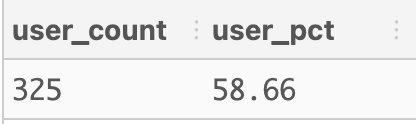

In [16]:
Image(filename="./resources/ha6.png")

There are 325 users or 58.66% of the user base who have logged blood glucose measurements

- Original query was missing percentage calculation
- Incorrect use of ```is``` in ```WHERE``` clause
- Incorrect condition in ```WHERE``` clause

***
***

```7. What is the number and percentage of users who have at least 2 types of measurements?```

```sql
SELECT
  COUNT(*) total_users,
  COUNT(*) FILTER (WHERE unique_measures>=2) user_count,
  ROUND(100 * COUNT(*) FILTER(WHERE unique_measures>=2)::NUMERIC / COUNT(*), 2) user_pct
FROM user_measure_count
```

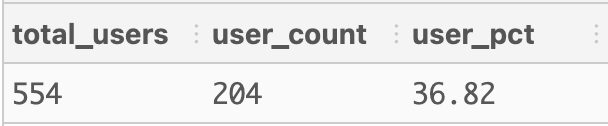

In [19]:
Image(filename="./resources/ha7.png")

Out of 554 users, 204 users or 36.82% have logged at least 2 types of measurements.

- Original query had wrong filter condition

***
***

```8. What is the number and percentage of users who have all 3 measures - blood glucose, weight and blood pressure?```

```sql
SELECT
  COUNT(*) total_users,
  COUNT(*) FILTER (WHERE unique_measures=3) user_count,
  ROUND(100 * COUNT(*) FILTER(WHERE unique_measures=3)::NUMERIC / COUNT(*), 2) user_pct
FROM user_measure_count
```

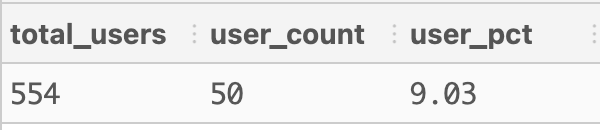

In [21]:
Image(filename="./resources/ha8.png")

Out of 554 users, 50 users or approximately 9% have logged a measurement of all 3 measures.

- Original query mispelt the temporary table name

***
***

```9. For users that have blood pressure measurements, what is the median systolic/diastolic blood pressure values?```

```sql
SELECT
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY systolic) AS median_systolic,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY diastolic) AS median_diastolic
FROM health.user_logs
WHERE measure = 'blood_pressure';

```

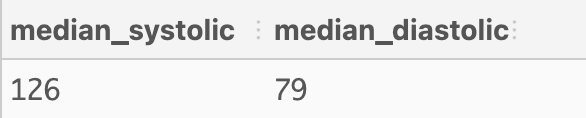

In [22]:
Image(filename="./resources/ha9.png")

The meadian value for systolic and diastolic are 126 and 79 respectively.

- Original query has incorrect syntax in ```WHERE``` clause and a missing comma

***
***